# 時系列データの分析


In [1]:
pip install optuna

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
import lightgbm as lgb
import optuna.integration.lightgbm as lgbo
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import  accuracy_score
import gc

import warnings
warnings.simplefilter('ignore')
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from lightgbm import LGBMRegressor

時間情報：これには日付（'Date'）や各時間帯（0時～23時）のデータが含まれます。

風速情報：'WSR0'～'WSR23', 'WSR_PK', 'WSR_AV' など、時間帯による風速や、最大・平均風速のデータが含まれています。

気温情報：'T0'～'T23', 'T_PK', 'T_AV', 'T85', 'T70' など、時間帯による気温や、最高・平均気温、さらに特定の気圧面（850ヘクトパスカルや700ヘクトパスカルなど）での気温が含まれています。

大気情報：'RH85', 'U85', 'V85', 'HT85', 'HT50' など、特定の気圧面での相対湿度、風速、高度などが含まれます。

気象指数：'KI', 'TT' など、特定の気象指数が含まれます。

気圧情報：'SLP', 'SLP_' など、海面気圧やその変化量が含まれています。

降水情報：'Precp'、これは降水量を示しています。

オゾンレベル：'OZONE'、これはクラスラベルで、オゾンレベルが高いか通常かを示しています。

年月日関連特徴量の追加

In [3]:
train =  pd.read_csv("train.tsv",sep='\t',index_col="Date",parse_dates=True)
test = pd.read_csv("test.tsv",sep='\t',index_col="Date",parse_dates=True)
submit = pd.read_csv("sample_submit.csv",header=None)

In [4]:
print(train.shape,test.shape,submit.shape)

# 時系列データをdatetime型にする
train["Date"] = train.index
test["Date"] = test.index
train['year'] = pd.to_datetime(train["Date"]).dt.year
test['year'] = pd.to_datetime(test["Date"]).dt.year
train['month'] = pd.to_datetime(train["Date"]).dt.month
test['month'] = pd.to_datetime(test["Date"]).dt.month
train['day'] = pd.to_datetime(train["Date"]).dt.day
test['day'] = pd.to_datetime(test["Date"]).dt.day
train['dayofweek'] = pd.to_datetime(train["Date"]).dt.dayofweek
test['dayofweek'] = pd.to_datetime(test["Date"]).dt.dayofweek
train = train.drop("Date",axis=1)
test = test.drop("Date",axis=1)
train = pd.get_dummies(train, columns=["dayofweek"])
test = pd.get_dummies(test, columns=["dayofweek"])

(1267, 74) (1267, 73) (1267, 2)


In [5]:
all = pd.concat([train,test]).reset_index(drop=True)
y_data = train["OZONE"]

In [6]:
print("データ形状：")
print(all.shape)

print("データ数：")
print(len(all))

print("データのコラム数")
print(len(all.columns))

print("データのコラム数名")
print(all.columns)

print("コラムのデータ型")
print(all.dtypes)

データ形状：
(2534, 84)
データ数：
2534
データのコラム数
84
データのコラム数名
Index(['id', 'WSR0', 'WSR1', 'WSR2', 'WSR3', 'WSR4', 'WSR5', 'WSR6', 'WSR7',
       'WSR8', 'WSR9', 'WSR10', 'WSR11', 'WSR12', 'WSR13', 'WSR14', 'WSR15',
       'WSR16', 'WSR17', 'WSR18', 'WSR19', 'WSR20', 'WSR21', 'WSR22', 'WSR23',
       'WSR_PK', 'WSR_AV', 'T0', 'T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'T7',
       'T8', 'T9', 'T10', 'T11', 'T12', 'T13', 'T14', 'T15', 'T16', 'T17',
       'T18', 'T19', 'T20', 'T21', 'T22', 'T23', 'T_PK', 'T_AV', 'T85', 'RH85',
       'U85', 'V85', 'HT85', 'T70', 'RH70', 'U70', 'V70', 'HT70', 'T50',
       'RH50', 'U50', 'V50', 'HT50', 'KI', 'TT', 'SLP', 'SLP_', 'Precp',
       'OZONE', 'year', 'month', 'day', 'dayofweek_0', 'dayofweek_1',
       'dayofweek_2', 'dayofweek_3', 'dayofweek_4', 'dayofweek_5',
       'dayofweek_6'],
      dtype='object')
コラムのデータ型
id               int64
WSR0           float64
WSR1           float64
WSR2           float64
WSR3           float64
                ...   
dayofweek_2

In [7]:
all.isnull().sum()

id               0
WSR0           299
WSR1           292
WSR2           294
WSR3           292
              ... 
dayofweek_2      0
dayofweek_3      0
dayofweek_4      0
dayofweek_5      0
dayofweek_6      0
Length: 84, dtype: int64

In [8]:
all = pd.concat([train,test]).reset_index(drop=True)
y_data = train["OZONE"]

#欠損値をLGBMで埋め合わせ
all0 = pd.DataFrame(IterativeImputer(estimator=LGBMRegressor(random_state=42)).fit_transform(all.drop("OZONE",axis=1)),
                    columns=all.drop("OZONE",axis=1).columns)

# 3日間の移動平均風速を計算
all0['WSR_AVG_3D'] = all0['WSR_AV'].rolling(window=3).mean()
# 3日間の移動平均気温を計算
all0['T_AVG_3D'] = all0['T_AV'].rolling(window=3).mean()
# 7日間の移動平均風速を計算
all0['WSR_AVG_7D'] = all0['WSR_AV'].rolling(window=7).mean()
# 7日間の移動平均気温を計算
all0['T_AVG_7D'] = all0['T_AV'].rolling(window=7).mean()
# 3日間の移動標準偏差風速を計算
all0['WSR_STD_3D'] = all0['WSR_AV'].rolling(window=3).std()
# 3日間の移動標準偏差気温を計算
all0['T_STD_3D'] = all0['T_AV'].rolling(window=3).std()
# 7日間の移動標準偏差風速を計算
all0['WSR_STD_7D'] = all0['WSR_AV'].rolling(window=7).std()
# 7日間の移動標準偏差気温を計算
all0['T_STD_7D'] = all0['T_AV'].rolling(window=7).std()

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001092 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11586
[LightGBM] [Info] Number of data points in the train set: 2534, number of used features: 82
[LightGBM] [Info] Start training from score 1266.500000
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001691 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11833
[LightGBM] [Info] Number of data points in the train set: 2534, number of used features: 82
[LightGBM] [Info] Start training from score 2001.008287
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of te

In [9]:

all0['WSR_AVG_3D'] = all0['WSR_AVG_3D'].fillna(all0['WSR_AVG_3D'].mean())
all0['T_AVG_3D'] = all0['T_AVG_3D'].fillna(all0['T_AVG_3D'].mean())
all0['WSR_AVG_7D'] = all0['WSR_AVG_7D'].fillna(all0['WSR_AVG_7D'].mean())
all0['T_AVG_7D'] = all0['T_AVG_7D'].fillna(all0['T_AVG_7D'].mean())
all0['WSR_STD_3D'] = all0['WSR_STD_3D'].fillna(all0['WSR_STD_3D'].mean())
all0['T_STD_3D'] = all0['T_STD_3D'].fillna(all0['T_STD_3D'].mean())
all0['WSR_STD_7D'] = all0['WSR_STD_7D'].fillna(all0['WSR_STD_7D'].mean())
all0['T_STD_7D'] = all0['T_STD_7D'].fillna(all0['T_STD_7D'].mean())

In [10]:
all0.isnull().sum()

id            0
WSR0          0
WSR1          0
WSR2          0
WSR3          0
             ..
T_AVG_7D      0
WSR_STD_3D    0
T_STD_3D      0
WSR_STD_7D    0
T_STD_7D      0
Length: 91, dtype: int64

In [11]:
all0.head(5)

,id,WSR0,WSR1,WSR2,WSR3,WSR4,WSR5,WSR6,WSR7,WSR8,...,dayofweek_5,dayofweek_6,WSR_AVG_3D,T_AVG_3D,WSR_AVG_7D,T_AVG_7D,WSR_STD_3D,T_STD_3D,WSR_STD_7D,T_STD_7D
0,0.0,0.8,1.8,2.4,2.1,2.0,2.1,1.5,1.7,1.9,...,0.0,0.0,2.313241,20.854107,2.31278,20.860714,0.523303,1.706456,0.644938,2.372458
1,1.0,2.8,3.2,3.3,2.7,3.3,3.2,2.9,2.8,3.1,...,0.0,0.0,2.313241,20.854107,2.31278,20.860714,0.523303,1.706456,0.644938,2.372458
2,2.0,2.9,2.8,2.6,2.1,2.2,2.5,2.5,2.7,2.2,...,1.0,0.0,3.333333,16.333333,2.31278,20.860714,0.208167,3.350124,0.644938,2.372458
3,3.0,4.7,3.8,3.7,3.8,2.9,3.1,2.8,2.5,2.4,...,0.0,1.0,3.366667,18.400000,2.31278,20.860714,0.152753,0.519615,0.644938,2.372458
4,4.0,2.6,2.1,1.6,1.4,0.9,1.5,1.2,1.4,1.3,...,0.0,0.0,3.000000,19.500000,2.31278,20.860714,0.624500,1.385641,0.644938,2.372458


In [ ]:
X_data = all0[:1267]
test = all0[1267:]

print(X_data.shape,test.shape)

(1267, 91) (1267, 91)


In [ ]:
print("データ形状：")
print(all0.shape)

print("データ数：")
print(len(all0))

print("データのコラム数")
print(len(all0.columns))

print("データのコラム数名")
print(all0.columns)

print("コラムのデータ型")
print(all0.dtypes)

データ形状：
(2534, 91)
データ数：
2534
データのコラム数
91
データのコラム数名
Index(['id', 'WSR0', 'WSR1', 'WSR2', 'WSR3', 'WSR4', 'WSR5', 'WSR6', 'WSR7',
       'WSR8', 'WSR9', 'WSR10', 'WSR11', 'WSR12', 'WSR13', 'WSR14', 'WSR15',
       'WSR16', 'WSR17', 'WSR18', 'WSR19', 'WSR20', 'WSR21', 'WSR22', 'WSR23',
       'WSR_PK', 'WSR_AV', 'T0', 'T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'T7',
       'T8', 'T9', 'T10', 'T11', 'T12', 'T13', 'T14', 'T15', 'T16', 'T17',
       'T18', 'T19', 'T20', 'T21', 'T22', 'T23', 'T_PK', 'T_AV', 'T85', 'RH85',
       'U85', 'V85', 'HT85', 'T70', 'RH70', 'U70', 'V70', 'HT70', 'T50',
       'RH50', 'U50', 'V50', 'HT50', 'KI', 'TT', 'SLP', 'SLP_', 'Precp',
       'year', 'month', 'day', 'dayofweek_0', 'dayofweek_1', 'dayofweek_2',
       'dayofweek_3', 'dayofweek_4', 'dayofweek_5', 'dayofweek_6',
       'WSR_AVG_3D', 'T_AVG_3D', 'WSR_AVG_7D', 'T_AVG_7D', 'WSR_STD_3D',
       'T_STD_3D', 'WSR_STD_7D', 'T_STD_7D'],
      dtype='object')
コラムのデータ型
id            float64
WSR0          float64
WSR

Text(0.5, 1.0, 'Correlation Heatmap')

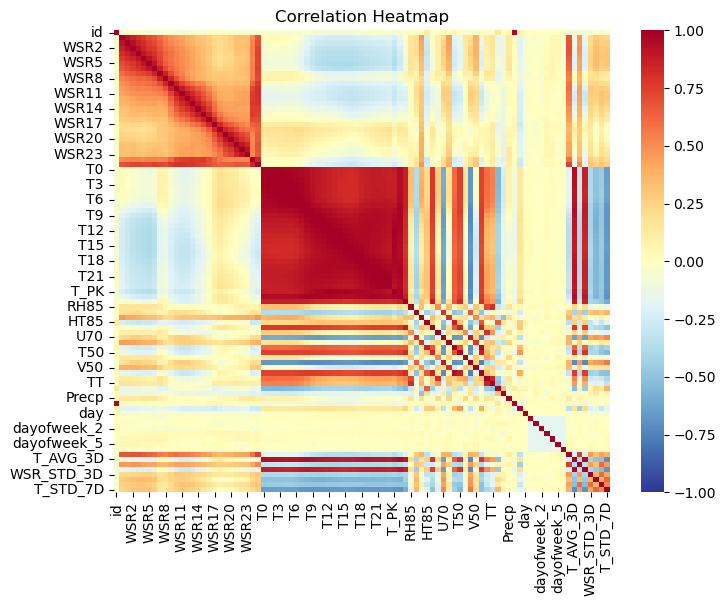

In [ ]:
ext_data = X_data
ext_data_corrs = ext_data.corr()

plt.figure(figsize = (8, 6))
# Heatmap of correlations
sns.heatmap(ext_data_corrs, cmap = plt.cm.RdYlBu_r, vmin = -1.0, vmax = 1.0)
plt.title('Correlation Heatmap')

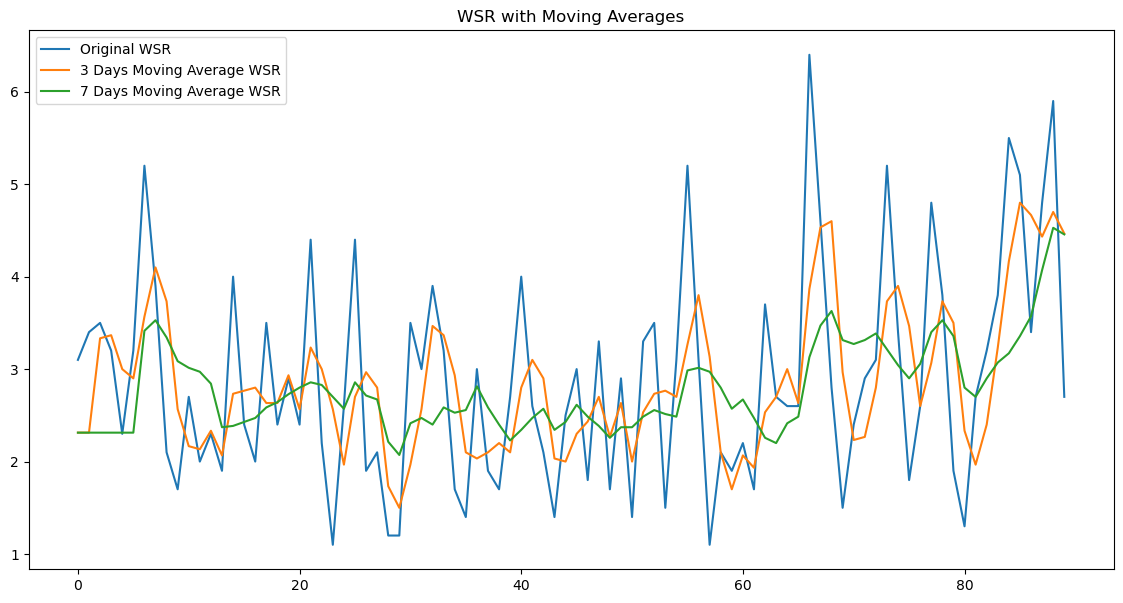

In [ ]:
# 平均風速と移動平均、最初の3か月
X_1month = all0[:90]

plt.figure(figsize=(14,7))
plt.plot(X_1month['id'], X_1month['WSR_AV'], label='Original WSR')
plt.plot(X_1month['id'], X_1month['WSR_AVG_3D'], label='3 Days Moving Average WSR')
plt.plot(X_1month['id'], X_1month['WSR_AVG_7D'], label='7 Days Moving Average WSR')
plt.legend(loc='best')
plt.title('WSR with Moving Averages')
plt.show()

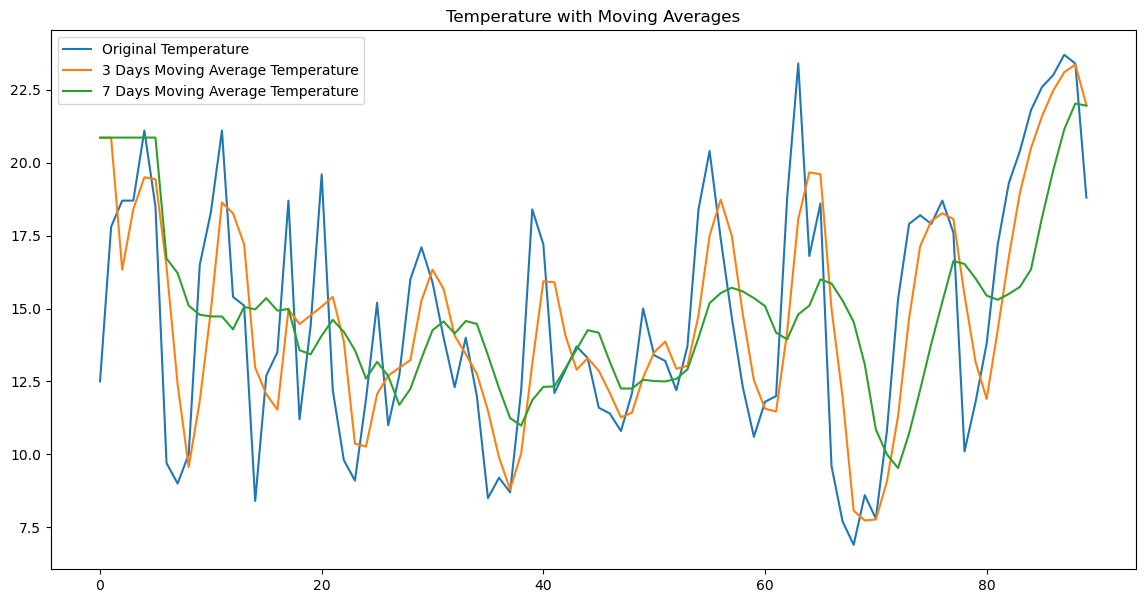

In [ ]:
# 平均気温と移動平均、最初の3か月

plt.figure(figsize=(14,7))
plt.plot(X_1month['id'], X_1month['T_AV'], label='Original Temperature')
plt.plot(X_1month['id'], X_1month['T_AVG_3D'], label='3 Days Moving Average Temperature')
plt.plot(X_1month['id'], X_1month['T_AVG_7D'], label='7 Days Moving Average Temperature')
plt.legend(loc='best')
plt.title('Temperature with Moving Averages')
plt.show()

In [ ]:
print(X_data.info())
print()
print(test.info())

print(X_data.describe())
print()
print(test.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1267 entries, 0 to 1266
Data columns (total 91 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           1267 non-null   float64
 1   WSR0         1267 non-null   float64
 2   WSR1         1267 non-null   float64
 3   WSR2         1267 non-null   float64
 4   WSR3         1267 non-null   float64
 5   WSR4         1267 non-null   float64
 6   WSR5         1267 non-null   float64
 7   WSR6         1267 non-null   float64
 8   WSR7         1267 non-null   float64
 9   WSR8         1267 non-null   float64
 10  WSR9         1267 non-null   float64
 11  WSR10        1267 non-null   float64
 12  WSR11        1267 non-null   float64
 13  WSR12        1267 non-null   float64
 14  WSR13        1267 non-null   float64
 15  WSR14        1267 non-null   float64
 16  WSR15        1267 non-null   float64
 17  WSR16        1267 non-null   float64
 18  WSR17        1267 non-null   float64
 19  WSR18 

In [ ]:
X_data.isnull().sum()

id            0
WSR0          0
WSR1          0
WSR2          0
WSR3          0
             ..
T_AVG_7D      0
WSR_STD_3D    0
T_STD_3D      0
WSR_STD_7D    0
T_STD_7D      0
Length: 91, dtype: int64

In [ ]:
X_data

,id,WSR0,WSR1,WSR2,WSR3,WSR4,WSR5,WSR6,WSR7,WSR8,...,dayofweek_5,dayofweek_6,WSR_AVG_3D,T_AVG_3D,WSR_AVG_7D,T_AVG_7D,WSR_STD_3D,T_STD_3D,WSR_STD_7D,T_STD_7D
0,0.0,0.8,1.8,2.4,2.1,2.0,2.1,1.5,1.7,1.9,...,0.0,0.0,2.313241,20.854107,2.312780,20.860714,0.523303,1.706456,0.644938,2.372458
1,1.0,2.8,3.2,3.3,2.7,3.3,3.2,2.9,2.8,3.1,...,0.0,0.0,2.313241,20.854107,2.312780,20.860714,0.523303,1.706456,0.644938,2.372458
2,2.0,2.9,2.8,2.6,2.1,2.2,2.5,2.5,2.7,2.2,...,1.0,0.0,3.333333,16.333333,2.312780,20.860714,0.208167,3.350124,0.644938,2.372458
3,3.0,4.7,3.8,3.7,3.8,2.9,3.1,2.8,2.5,2.4,...,0.0,1.0,3.366667,18.400000,2.312780,20.860714,0.152753,0.519615,0.644938,2.372458
4,4.0,2.6,2.1,1.6,1.4,0.9,1.5,1.2,1.4,1.3,...,0.0,0.0,3.000000,19.500000,2.312780,20.860714,0.624500,1.385641,0.644938,2.372458
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1262,1262.0,0.8,0.9,0.3,0.3,0.7,0.8,1.3,1.9,3.0,...,0.0,0.0,1.633333,26.733333,1.585714,26.485714,0.057735,0.929157,0.219306,0.651738
1263,1263.0,1.0,0.7,0.8,0.6,0.9,1.2,1.3,1.7,2.8,...,1.0,0.0,1.766667,26.533333,1.685714,26.557143,0.208167,0.723418,0.226779,0.667975
1264,1264.0,0.7,1.0,1.4,0.9,1.0,1.2,1.4,1.4,1.1,...,0.0,1.0,1.900000,25.800000,1.728571,26.300000,0.173205,1.053565,0.256348,0.939858
1265,1265.0,1.7,1.7,1.1,1.3,1.0,1.0,1.2,1.8,1.8,...,0.0,0.0,1.800000,25.500000,1.657143,26.057143,0.346410,1.212436,0.269921,1.087592


In [20]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import GradientBoostingRegressor

# estimatorとしてGBDTを使用。特徴量を5個選択
selector = RFE(GradientBoostingRegressor(n_estimators=100, random_state=10), n_features_to_select=45)
selector.fit(X_data, y_data)
mask = selector.get_support()
#print(X.feature_names)
print(mask)

# 選択した特徴量の列のみ取得
X_selected = selector.transform(X_data)
print("X.shape={}, X_selected.shape={}".format(X_data.shape, X_selected.shape))

[ True  True  True False  True False False  True False False False  True
  True  True  True False  True False  True False  True False  True False
  True False  True False  True False False  True  True False False  True
  True False False False  True  True  True False False  True  True False
 False False False  True False  True  True  True  True False  True  True
  True  True False  True  True  True False False  True  True False False
 False False False False False False False False False False False  True
  True  True  True False  True  True False]
X.shape=(1267, 91), X_selected.shape=(1267, 45)


In [24]:
selected = []
not_selected = []
columns = X_data.columns

for i in range(0, len(mask)):
    
    value = mask[i]
    
    if (value == True):
        selected.append(columns[i])
    else:
        not_selected.append(columns[i])

print("選択された45の特徴量：")
print(selected)

print("除外された特徴量：")
print(not_selected)

選択された45の特徴量：
['id', 'WSR0', 'WSR1', 'WSR3', 'WSR6', 'WSR10', 'WSR11', 'WSR12', 'WSR13', 'WSR15', 'WSR17', 'WSR19', 'WSR21', 'WSR23', 'WSR_AV', 'T1', 'T4', 'T5', 'T8', 'T9', 'T13', 'T14', 'T15', 'T18', 'T19', 'T_PK', 'T85', 'RH85', 'U85', 'V85', 'T70', 'RH70', 'U70', 'V70', 'T50', 'RH50', 'U50', 'KI', 'TT', 'WSR_AVG_3D', 'T_AVG_3D', 'WSR_AVG_7D', 'T_AVG_7D', 'T_STD_3D', 'WSR_STD_7D']
除外された特徴量：
['WSR2', 'WSR4', 'WSR5', 'WSR7', 'WSR8', 'WSR9', 'WSR14', 'WSR16', 'WSR18', 'WSR20', 'WSR22', 'WSR_PK', 'T0', 'T2', 'T3', 'T6', 'T7', 'T10', 'T11', 'T12', 'T16', 'T17', 'T20', 'T21', 'T22', 'T23', 'T_AV', 'HT85', 'HT70', 'V50', 'HT50', 'SLP', 'SLP_', 'Precp', 'year', 'month', 'day', 'dayofweek_0', 'dayofweek_1', 'dayofweek_2', 'dayofweek_3', 'dayofweek_4', 'dayofweek_5', 'dayofweek_6', 'WSR_STD_3D', 'T_STD_7D']


In [28]:
X_data_selected = X_data[selected]
test_selected = test[selected]

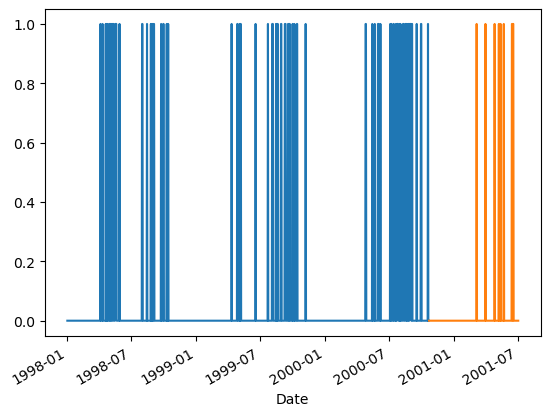

In [29]:
X_train, X_val, y_train, y_val = train_test_split(X_data_selected,y_data,test_size=0.2,shuffle=False)

y_train.plot()
y_val.plot()
plt.show()

In [31]:
# LGBMでモデル学習

dtrain = lgb.Dataset(X_train, label=y_train)
eval_data = lgb.Dataset(X_val, label=y_val, reference=dtrain)

params = {
         'objective': 'binary',
         'metric': 'binary_logloss',
         'learning_rate':0.01,
         'verbose':-1
         }
best = lgbo.train(params,
                  dtrain,
                  valid_sets=eval_data,
                  # early_stopping_rounds=200,
                  num_boost_round=100,
                  # verbose_eval=10000
                  )

pred = best.predict(X_val)
pred_sub = best.predict(test_selected)
pred_labels = np.round(pred)
accuracy = accuracy_score(y_val, pred_labels)
print("検証精度：")
print(accuracy)

feature_importance_df = pd.DataFrame()
feature_importance_df["feature"] = X_train.columns
feature_importance_df["importance"] = best.feature_importance()
feature_importance_df["fold"] = 1

best_params = best.params
print("Best params:", best_params)

[I 2023-11-09 14:33:36,053] A new study created in memory with name: no-name-b079383b-62cb-48a3-862b-ad31c0cc30b1
min_child_samples, val_score: 0.123475: 100%|##########| 5/5 [00:00<00:00,  6.74it/s]

検証精度：
0.968503937007874
Best params: {'objective': 'binary', 'metric': 'binary_logloss', 'learning_rate': 0.01, 'verbose': -1, 'feature_pre_filter': False, 'lambda_l1': 1.4765397694175723e-05, 'lambda_l2': 0.0043397925949241615, 'num_leaves': 31, 'feature_fraction': 0.948, 'bagging_fraction': 0.619081287103433, 'bagging_freq': 3, 'min_child_samples': 20, 'num_iterations': 100}
